In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install matplotlib
!pip install seqeval

import torch
from seqeval.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sentencepiece
import transformers
from torch.utils.data import Dataset, TensorDataset ,DataLoader, RandomSampler, SequentialSampler
import sentencepiece as spm
from transformers import BertForTokenClassification, BertTokenizer, BertConfig, BertModel, AdamW
from transformers import ReformerPreTrainedModel, ReformerModel, ReformerConfig
from transformers.file_utils import add_start_docstrings_to_model_forward, add_code_sample_docstrings
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
from torch.nn import CrossEntropyLoss, MSELoss
import torch.nn as nn
from transformers.modeling_outputs import TokenClassifierOutput, SequenceClassifierOutput
_CONFIG_FOR_DOC = "ReformerConfig"
_TOKENIZER_FOR_DOC = "ReformerTokenizer"
_CHECKPOINT_FOR_DOC = "reformer-base-uncased"
REFORMER_INPUTS_DOCSTRING = r"""

    Args:
        input_ids (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`):
            Indices of input sequence tokens in the vocabulary. During training the input_ids sequence_length has to be
            a multiple of the relevant model's chunk lengths (lsh's, local's or both). During evaluation, the indices
            are automatically padded to be a multiple of the chunk length.

            Indices can be obtained using :class:`~transformers.ReformerTokenizer`. See
            :meth:`transformers.PreTrainedTokenizer.encode` and :meth:`transformers.PreTrainedTokenizer.__call__` for
            details.

            `What are input IDs? <../glossary.html#input-ids>`__
        attention_mask (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Mask to avoid performing attention on padding token indices. Mask values selected in ``[0, 1]``:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.

            `What are attention masks? <../glossary.html#attention-mask>`__
        position_ids (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Indices of positions of each input sequence tokens in the position embeddings. Selected in the range ``[0,
            config.max_position_embeddings - 1]``.

            `What are position IDs? <../glossary.html#position-ids>`__
        head_mask (:obj:`torch.FloatTensor` of shape :obj:`(num_heads,)` or :obj:`(num_layers, num_heads)`, `optional`):
            Mask to nullify selected heads of the self-attention modules. Mask values selected in ``[0, 1]``:

            - 1 indicates the head is **not masked**,
            - 0 indicates the head is **masked**.

        inputs_embeds (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length, hidden_size)`, `optional`):
            Optionally, instead of passing :obj:`input_ids` you can choose to directly pass an embedded representation.
            This is useful if you want more control over how to convert :obj:`input_ids` indices into associated
            vectors than the model's internal embedding lookup matrix.
        num_hashes (:obj:`int`, `optional`):
            The number of hashing rounds that should be performed during bucketing. Setting this argument overwrites
            the default defined in :obj:`config.num_hashes`.

            For more information, see :obj:`num_hashes` in :class:`~transformers.ReformerConfig`.
        past_buckets_states (:obj:`List[Tuple(torch.LongTensor, torch.FloatTensor)]`, `optional`):
            List of :obj:`Tuple(torch.LongTensor, torch.FloatTensor` of length :obj:`config.n_layers`, with the first
            element being the previous `buckets` of shape :obj:`(batch_size, num_heads, num_hashes, sequence_length)`)
            and the second being the previous `hidden_states` of shape :obj:`(batch_size, sequence_length,
            hidden_size)`).

            Contains precomputed hidden-states and buckets (only relevant for LSH Self-Attention). Can be used to speed
            up sequential decoding.
        use_cache (:obj:`bool`, `optional`):
            If set to :obj:`True`, :obj:`past_key_values` key value states are returned and can be used to speed up
            decoding (see :obj:`past_key_values`).
        output_attentions (:obj:`bool`, `optional`):
            Whether or not to return the attentions tensors of all attention layers. See ``attentions`` under returned
            tensors for more detail.
        output_hidden_states (:obj:`bool`, `optional`):
            Whether or not to return the hidden states of all layers. See ``hidden_states`` under returned tensors for
            more detail.
        return_dict (:obj:`bool`, `optional`):
            Whether or not to return a :class:`~transformers.file_utils.ModelOutput` instead of a plain tuple.
"""

class ReformerTokenClassification(ReformerPreTrainedModel):

    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.reformer = ReformerModel(config)
        self.classifier = torch.nn.Linear(2*config.hidden_size, config.num_labels)

        self.init_weights()

    @add_start_docstrings_to_model_forward(REFORMER_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    @add_code_sample_docstrings(
        tokenizer_class=_TOKENIZER_FOR_DOC,
        checkpoint=_CHECKPOINT_FOR_DOC,
        output_type=TokenClassifierOutput,
        config_class=_CONFIG_FOR_DOC,
    )
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        #token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the token classification loss. Indices should be in ``[0, ..., config.num_labels -
            1]``.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.reformer(
            input_ids,
            attention_mask=attention_mask,
            #token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]
        #print("------------","sequence_output: ", sequence_output,sequence_output.size(), "-------------------")
        logits = self.classifier(sequence_output)
        #print("------------","logits: ", logits,logits.size(),"-------------------")
        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            # Only keep active parts of the loss
            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                #print("------------","active_loss: ", active_loss,active_loss.size(),"-------------------")
                active_logits = logits.view(-1, self.num_labels)
                #print("------------","active_logits: ", active_logits,active_logits.size(), "-------------------")
                active_labels = torch.where(
                    active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                )
                #print("------------","active_labels: ", active_labels,active_labels.size(),"-------------------")
                loss = loss_fct(active_logits, active_labels)
                #print("------------","loss: ", loss,loss.size(), "-------------------")
            else:
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            print("------------","output: ", output,"-------------------")
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )



In [ ]:
config = transformers.ReformerConfig(num_buckets=128, num_labels=18, vocab_size=30522,axial_pos_shape=[16,8], 
                                     dropout=0.5,
                                     attn_layers=['local', 'lsh', 'local', 'lsh', 'local', 'lsh','local', 'lsh', 'local', 'lsh', 'local', 'lsh'])
nermodel = ReformerTokenClassification(config)
config = nermodel.config

In [ ]:
nermodel = ReformerTokenClassification(config = config)

In [ ]:
#model = REFORMER()
nermodel

In [ ]:
from tqdm import tqdm, trange

data = pd.read_csv("ner_dataset.csv", encoding="latin1").fillna(method="ffill")
data.tail(5)

,Sentence #,Word,POS,Tag
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [ ]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [ ]:
getter = SentenceGetter(data)

In [ ]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

In [ ]:
labels = [[s[2] for s in sentence] for sentence in getter.sentences]
print(labels[0])

In [ ]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}
tag2idx #ReformerModelWithBertTokenizer-100 epochs

In [ ]:
MAX_LEN = 128
bs = 32

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [ ]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
tokens = tokenizer("They marched from the Houses of Parliament to a rally in Hyde Park .")
tokens

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [ ]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [ ]:
#tokenized_texts_and_labels[38377]

In [ ]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.2)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.2)

In [ ]:
#val_inputs[0]

In [ ]:
#val_tags[0]

In [ ]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [ ]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
print(len(train_data))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
print(len(valid_data))
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

38367
9592


In [ ]:
nermodel.cuda();

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(nermodel.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters, lr=0.00001,
    eps=1e-12
)
print(optimizer)

AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-12
    lr: 1e-05
    weight_decay: 0.0
    weight_decay_rate: 0.01

Parameter Group 1
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-12
    lr: 1e-05
    weight_decay: 0.0
    weight_decay_rate: 0.0
)


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 100
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [ ]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values, f1_scores = [], [], []
for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    nermodel.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        nermodel.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = nermodel(b_input_ids,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=nermodel.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    nermodel.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = nermodel(b_input_ids,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score([pred_tags], [valid_tags])))
    f1 = f1_score([pred_tags], [valid_tags])
    f1_scores.append(f1)
    print(f1_scores)
    print()


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/transformers/models/reformer/modeling_reformer.py:1164: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorCompare.cpp:255.)
  query_key_dots = torch.where(mask, query_key_dots, mask_value)


Average train loss: 0.9257989505413078
Validation loss: 0.9004161155223847
Validation Accuracy: 0.7981489825190868
Validation F1-Score: 0.0


Epoch:   1%|          | 1/100 [11:41<19:17:11, 701.33s/it]

[0.0]

Average train loss: 0.8152376579383297
Validation loss: 0.6075892328222593
Validation Accuracy: 0.8233514246386217
Validation F1-Score: 0.19232221522970422


Epoch:   2%|▏         | 2/100 [26:10<21:46:59, 800.19s/it]

[0.0, 0.19232221522970422]

Average train loss: 0.5934967309161958
Validation loss: 0.5318343054254849
Validation Accuracy: 0.8407248647285684
Validation F1-Score: 0.25009648784253186


Epoch:   3%|▎         | 3/100 [40:50<22:32:17, 836.47s/it]

[0.0, 0.19232221522970422, 0.25009648784253186]

Average train loss: 0.5242856452125028
Validation loss: 0.48744851728280386
Validation Accuracy: 0.8485414660157655
Validation F1-Score: 0.26283526041589356


Epoch:   4%|▍         | 4/100 [55:21<22:40:16, 850.17s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356]

Average train loss: 0.4912026621482092
Validation loss: 0.47310721943775813
Validation Accuracy: 0.8527039818783818
Validation F1-Score: 0.28138496233951915


Epoch:   5%|▌         | 5/100 [1:10:00<22:42:45, 860.69s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915]

Average train loss: 0.463294413757881
Validation loss: 0.4527953587969144
Validation Accuracy: 0.8594169170927699
Validation F1-Score: 0.3204017216642755


Epoch:   6%|▌         | 6/100 [1:24:38<22:37:11, 866.29s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755]

Average train loss: 0.4363240113200696
Validation loss: 0.41501789490381874
Validation Accuracy: 0.8709454739357063
Validation F1-Score: 0.36238789641124564


Epoch:   7%|▋         | 7/100 [1:39:15<22:28:30, 870.00s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564]

Average train loss: 0.4106103095340172
Validation loss: 0.42713599840799965
Validation Accuracy: 0.8677998189491611
Validation F1-Score: 0.3710964148973198


Epoch:   8%|▊         | 8/100 [1:53:55<22:18:59, 873.26s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198]

Average train loss: 0.38849992712057063
Validation loss: 0.3724401468038559
Validation Accuracy: 0.8875087321894337
Validation F1-Score: 0.4468603392277156


Epoch:   9%|▉         | 9/100 [2:08:36<22:07:46, 875.45s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156]

Average train loss: 0.3686196656153538
Validation loss: 0.39789929245909056
Validation Accuracy: 0.8792167691105774
Validation F1-Score: 0.4277652861391165


Epoch:  10%|█         | 10/100 [2:23:17<21:56:02, 877.36s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165]

Average train loss: 0.3523061056252417
Validation loss: 0.36556692510843275
Validation Accuracy: 0.8893068398361449
Validation F1-Score: 0.4661930185955915


Epoch:  11%|█         | 11/100 [2:37:54<21:41:01, 877.10s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915]

Average train loss: 0.33918728842846646
Validation loss: 0.3309423160056273
Validation Accuracy: 0.9022904171196382
Validation F1-Score: 0.5263950398582815


Epoch:  12%|█▏        | 12/100 [2:52:31<21:26:18, 877.03s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815]

Average train loss: 0.3271126021585234
Validation loss: 0.3299829466144244
Validation Accuracy: 0.9027740460728916
Validation F1-Score: 0.5339153595738384


Epoch:  13%|█▎        | 13/100 [3:07:05<21:10:23, 876.13s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384]

Average train loss: 0.317586844965654
Validation loss: 0.3281962386270364
Validation Accuracy: 0.902261482054059
Validation F1-Score: 0.5394614802870963


Epoch:  14%|█▍        | 14/100 [3:21:39<20:55:04, 875.64s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963]

Average train loss: 0.30842363930076633
Validation loss: 0.3292956876258055
Validation Accuracy: 0.9028029811384708
Validation F1-Score: 0.546889095725639


Epoch:  15%|█▌        | 15/100 [3:36:14<20:40:03, 875.34s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639]

Average train loss: 0.29989772885913546
Validation loss: 0.31407158096631366
Validation Accuracy: 0.907176309621736
Validation F1-Score: 0.5648223896663079


Epoch:  16%|█▌        | 16/100 [3:50:51<20:26:04, 875.77s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079]

Average train loss: 0.292403805954343
Validation loss: 0.3272080678741137
Validation Accuracy: 0.9028319162040501
Validation F1-Score: 0.5491479171307642


Epoch:  17%|█▋        | 17/100 [4:05:26<20:11:22, 875.70s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642]

Average train loss: 0.28664682414056464
Validation loss: 0.31335929994781814
Validation Accuracy: 0.9084577196688175
Validation F1-Score: 0.5654933310411026


Epoch:  18%|█▊        | 18/100 [4:20:03<19:57:06, 875.93s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026]

Average train loss: 0.28088697509605554
Validation loss: 0.29088531305392584
Validation Accuracy: 0.915092116848062
Validation F1-Score: 0.5954727418298275


Epoch:  19%|█▉        | 19/100 [4:34:40<19:42:54, 876.23s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275]

Average train loss: 0.2750527738306898
Validation loss: 0.2755946698784828
Validation Accuracy: 0.920006944415739
Validation F1-Score: 0.6217919658394631


Epoch:  20%|██        | 20/100 [4:49:16<19:28:30, 876.38s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631]

Average train loss: 0.269275531725798
Validation loss: 0.27493052517374356
Validation Accuracy: 0.9194117087809657
Validation F1-Score: 0.6187856710959044


Epoch:  21%|██        | 21/100 [5:03:54<19:14:21, 876.73s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044]

Average train loss: 0.26385704746735505
Validation loss: 0.27994369526704155
Validation Accuracy: 0.918890877600539
Validation F1-Score: 0.6203914626891659


Epoch:  22%|██▏       | 22/100 [5:18:31<18:59:57, 876.89s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659]

Average train loss: 0.2607085595499286
Validation loss: 0.26851672555009526
Validation Accuracy: 0.9222762802733123
Validation F1-Score: 0.6331974750967437


Epoch:  23%|██▎       | 23/100 [5:33:08<18:45:10, 876.76s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437]

Average train loss: 0.2553709639085642
Validation loss: 0.2666697942217191
Validation Accuracy: 0.923351011280542
Validation F1-Score: 0.641559908450495


Epoch:  24%|██▍       | 24/100 [5:47:47<18:31:25, 877.44s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495]

Average train loss: 0.250817581731593
Validation loss: 0.25834298682709533
Validation Accuracy: 0.9238966439457509
Validation F1-Score: 0.6412894678737028


Epoch:  25%|██▌       | 25/100 [6:02:25<18:17:01, 877.62s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028]

Average train loss: 0.24709901554794286
Validation loss: 0.27391658251484235
Validation Accuracy: 0.9202508256827642
Validation F1-Score: 0.6268082397870617


Epoch:  26%|██▌       | 26/100 [6:17:02<18:02:18, 877.55s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617]

Average train loss: 0.24363599129773061
Validation loss: 0.24529274811347326
Validation Accuracy: 0.9281749000706843
Validation F1-Score: 0.6645934218905032


Epoch:  27%|██▋       | 27/100 [6:31:39<17:47:23, 877.31s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032]

Average train loss: 0.24040731615553904
Validation loss: 0.2535147488117218
Validation Accuracy: 0.9264511968783198
Validation F1-Score: 0.6545060290390167


Epoch:  28%|██▊       | 28/100 [6:46:14<17:32:03, 876.71s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167]

Average train loss: 0.23597555121622849
Validation loss: 0.25074218357602757
Validation Accuracy: 0.9272200429065687
Validation F1-Score: 0.6601158250722092


Epoch:  29%|██▉       | 29/100 [7:00:50<17:17:19, 876.61s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092]

Average train loss: 0.23260845841717184
Validation loss: 0.26374675810337067
Validation Accuracy: 0.9253020614167435
Validation F1-Score: 0.6487068012674083


Epoch:  30%|███       | 30/100 [7:15:27<17:02:38, 876.55s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083]

Average train loss: 0.22978860283390098
Validation loss: 0.2548852625240882
Validation Accuracy: 0.9251036495384857
Validation F1-Score: 0.6459005996309963


Epoch:  31%|███       | 31/100 [7:30:03<16:47:44, 876.29s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963]

Average train loss: 0.22667337062335988
Validation loss: 0.2408185732613007
Validation Accuracy: 0.9296671227384146
Validation F1-Score: 0.6712358859452572


Epoch:  32%|███▏      | 32/100 [7:44:38<16:32:43, 875.94s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572]

Average train loss: 0.22386818743303877
Validation loss: 0.2666997532794873
Validation Accuracy: 0.9233386105381509
Validation F1-Score: 0.6405333257198327


Epoch:  33%|███▎      | 33/100 [7:59:14<16:18:23, 876.17s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327]

Average train loss: 0.22195425085891177
Validation loss: 0.24065764452020327
Validation Accuracy: 0.9306385142257183
Validation F1-Score: 0.6785186917937397


Epoch:  34%|███▍      | 34/100 [8:13:50<16:03:43, 876.12s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397]

Average train loss: 0.21934090385693525
Validation loss: 0.24429295289019742
Validation Accuracy: 0.9286626626047346
Validation F1-Score: 0.6663426071540903


Epoch:  35%|███▌      | 35/100 [8:28:27<15:49:19, 876.30s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903]

Average train loss: 0.2170069923405353
Validation loss: 0.24279415855805078
Validation Accuracy: 0.9303119613427524
Validation F1-Score: 0.6727622290385545


Epoch:  36%|███▌      | 36/100 [8:43:04<15:34:49, 876.40s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545]

Average train loss: 0.21472853357539365
Validation loss: 0.23625130526721477
Validation Accuracy: 0.9313494901228087
Validation F1-Score: 0.6802322172051839


Epoch:  37%|███▋      | 37/100 [8:57:41<15:20:23, 876.57s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839]

Average train loss: 0.21243938218314415
Validation loss: 0.2327213713278373
Validation Accuracy: 0.9320025958887406
Validation F1-Score: 0.6822904437661422


Epoch:  38%|███▊      | 38/100 [9:12:18<15:05:51, 876.63s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422]

Average train loss: 0.21059587528871634
Validation loss: 0.22982838628192742
Validation Accuracy: 0.9325812972003257
Validation F1-Score: 0.6848425455981513


Epoch:  39%|███▉      | 39/100 [9:23:36<13:50:43, 817.11s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513]

Average train loss: 0.20848480417541507
Validation loss: 0.22789880710343519
Validation Accuracy: 0.9336684289499465
Validation F1-Score: 0.6917097688553812


Epoch:  40%|████      | 40/100 [9:33:20<12:27:08, 747.14s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812]

Average train loss: 0.20620227575898667
Validation loss: 0.23630336053669454
Validation Accuracy: 0.9324366218724295
Validation F1-Score: 0.6837279804565054


Epoch:  41%|████      | 41/100 [9:43:26<11:33:11, 704.95s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054]

Average train loss: 0.20464160994279373
Validation loss: 0.23455364388724168
Validation Accuracy: 0.9335278872028472
Validation F1-Score: 0.6882636775295079


Epoch:  42%|████▏     | 42/100 [9:53:36<10:53:59, 676.54s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079]

Average train loss: 0.2030858526424232
Validation loss: 0.23227516122162342
Validation Accuracy: 0.9330235903456087
Validation F1-Score: 0.6917956178635982


Epoch:  43%|████▎     | 43/100 [10:02:26<10:00:54, 632.53s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982]

Average train loss: 0.20166302230628558
Validation loss: 0.2239619151999553
Validation Accuracy: 0.9345736831444976
Validation F1-Score: 0.69646385702

Epoch:  44%|████▍     | 44/100 [10:08:31<8:35:17, 552.10s/it] 

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741]

Average train loss: 0.1994486952680563
Validation loss: 0.22759670071303845
Validation Accuracy: 0.9339743139289272
Validation F1-

Epoch:  45%|████▌     | 45/100 [10:14:36<7:34:50, 496.19s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268]

Average train loss: 0.19780671508909764
Validation loss: 0.22141838853557905
Validation Accuracy: 0.9361568445

Epoch:  46%|████▌     | 46/100 [10:20:42<6:51:15, 456.95s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499]

Average train loss: 0.19673032961705011
Validation loss: 0.2327143548677365
Validation Accu

Epoch:  47%|████▋     | 47/100 [10:26:48<6:19:28, 429.60s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236]

Average train loss: 0.19463270293662108
Validation loss: 0.217333252380

Epoch:  48%|████▊     | 48/100 [10:32:54<5:55:50, 410.58s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576]

Average train loss: 0.19345992811651802
Validation 

Epoch:  49%|████▉     | 49/100 [10:39:01<5:37:57, 397.59s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904]

Average train loss: 0.191857013

Epoch:  50%|█████     | 50/100 [10:45:05<5:23:00, 387.61s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635]

Average tra

Epoch:  51%|█████     | 51/100 [10:51:12<5:11:22, 381.27s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  52%|█████▏    | 52/100 [10:57:20<5:01:50, 377.30s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  53%|█████▎    | 53/100 [11:03:26<4:52:56, 373.96s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  54%|█████▍    | 54/100 [11:09:32<4:44:51, 371.55s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  55%|█████▌    | 55/100 [11:15:37<4:37:18, 369.75s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  56%|█████▌    | 56/100 [11:21:43<4:30:16, 368.56s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  57%|█████▋    | 57/100 [11:27:49<4:23:31, 367.70s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  58%|█████▊    | 58/100 [11:33:55<4:16:58, 367.11s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  59%|█████▉    | 59/100 [11:40:00<4:10:33, 366.66s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  60%|██████    | 60/100 [11:46:05<4:04:08, 366.20s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  61%|██████    | 61/100 [11:52:08<3:57:21, 365.17s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  62%|██████▏   | 62/100 [11:58:11<3:50:54, 364.58s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  63%|██████▎   | 63/100 [12:04:15<3:44:42, 364.38s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  64%|██████▍   | 64/100 [12:10:20<3:38:36, 364.36s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  65%|██████▌   | 65/100 [12:16:26<3:32:50, 364.88s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  66%|██████▌   | 66/100 [12:22:32<3:26:54, 365.14s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  67%|██████▋   | 67/100 [12:28:38<3:21:06, 365.66s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  68%|██████▊   | 68/100 [12:34:46<3:15:15, 366.12s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  69%|██████▉   | 69/100 [12:40:51<3:09:04, 365.96s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  70%|███████   | 70/100 [12:46:53<3:02:21, 364.73s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  71%|███████   | 71/100 [12:52:56<2:56:05, 364.34s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  72%|███████▏  | 72/100 [12:58:58<2:49:36, 363.45s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  73%|███████▎  | 73/100 [13:05:00<2:43:26, 363.22s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  74%|███████▍  | 74/100 [13:11:01<2:37:01, 362.35s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  75%|███████▌  | 75/100 [13:17:02<2:30:50, 362.02s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  76%|███████▌  | 76/100 [13:23:03<2:24:42, 361.78s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  77%|███████▋  | 77/100 [13:29:03<2:18:26, 361.17s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  78%|███████▊  | 78/100 [13:35:04<2:12:25, 361.14s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  79%|███████▉  | 79/100 [13:41:07<2:06:34, 361.62s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  80%|████████  | 80/100 [13:47:08<2:00:29, 361.45s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  81%|████████  | 81/100 [13:53:10<1:54:30, 361.61s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  82%|████████▏ | 82/100 [13:59:10<1:48:19, 361.06s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  83%|████████▎ | 83/100 [14:05:10<1:42:15, 360.91s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  84%|████████▍ | 84/100 [14:11:11<1:36:15, 360.98s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  85%|████████▌ | 85/100 [14:17:13<1:30:15, 361.04s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  86%|████████▌ | 86/100 [14:23:13<1:24:13, 360.95s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  87%|████████▋ | 87/100 [14:29:14<1:18:11, 360.88s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  88%|████████▊ | 88/100 [14:35:16<1:12:13, 361.14s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  89%|████████▉ | 89/100 [14:41:18<1:06:15, 361.39s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  90%|█████████ | 90/100 [14:47:17<1:00:07, 360.75s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  91%|█████████ | 91/100 [14:53:16<54:03, 360.37s/it]  

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  92%|█████████▏| 92/100 [14:59:17<48:04, 360.55s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  93%|█████████▎| 93/100 [15:05:18<42:04, 360.64s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  94%|█████████▍| 94/100 [15:11:20<36:05, 360.94s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  95%|█████████▌| 95/100 [15:17:20<30:02, 360.57s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  96%|█████████▌| 96/100 [15:23:21<24:03, 360.83s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  97%|█████████▋| 97/100 [15:29:23<18:03, 361.06s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  98%|█████████▊| 98/100 [15:35:23<12:01, 360.91s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch:  99%|█████████▉| 99/100 [15:41:25<06:01, 361.16s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

Epoch: 100%|██████████| 100/100 [15:47:25<00:00, 568.45s/it]

[0.0, 0.19232221522970422, 0.25009648784253186, 0.26283526041589356, 0.28138496233951915, 0.3204017216642755, 0.36238789641124564, 0.3710964148973198, 0.4468603392277156, 0.4277652861391165, 0.4661930185955915, 0.5263950398582815, 0.5339153595738384, 0.5394614802870963, 0.546889095725639, 0.5648223896663079, 0.5491479171307642, 0.5654933310411026, 0.5954727418298275, 0.6217919658394631, 0.6187856710959044, 0.6203914626891659, 0.6331974750967437, 0.641559908450495, 0.6412894678737028, 0.6268082397870617, 0.6645934218905032, 0.6545060290390167, 0.6601158250722092, 0.6487068012674083, 0.6459005996309963, 0.6712358859452572, 0.6405333257198327, 0.6785186917937397, 0.6663426071540903, 0.6727622290385545, 0.6802322172051839, 0.6822904437661422, 0.6848425455981513, 0.6917097688553812, 0.6837279804565054, 0.6882636775295079, 0.6917956178635982, 0.6964638570206741, 0.6937111345770268, 0.702957742325499, 0.6905972883840236, 0.7072620790629576, 0.7059730707633904, 0.7004743651877635, 0.6985999386

In [ ]:
PATH = "ModelBT100E38KNERDATASET.pt"
torch.save(nermodel.state_dict(), PATH)

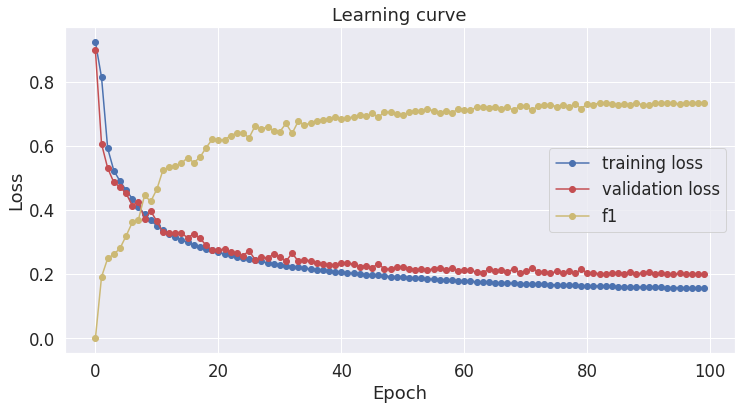

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")
plt.plot(f1_scores, 'y-o', label="f1")
# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [ ]:
#nermodel.load_state_dict(torch.load("ModelWithBertTokenizer50E38K.pt"))

In [ ]:
#nermodel.eval()

In [ ]:
#test_sentence = "The Joint Coordination and Monitoring Board Monday , says insurgent violence has killed 3700 people so far this year , most of them rebels."
#test_sentence = "Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country."
test_sentence = "Who are the developers of Skype?"

In [ ]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence])

In [ ]:
with torch.no_grad():
    output = nermodel(input_ids.to(device))
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
print(label_indices)

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(input_ids.numpy()[0])
print(tokens)

new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else: 
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)
print(new_labels)

In [ ]:
entities = []
for token, label in zip(new_tokens, new_labels):
    if label != "O":
        print("{}\t{}".format(label, token))
        entities.append(token.lower())
        #entities.append(token)
print(test_sentence)
print(entities)        
        

B-org	Skype
Who are the developers of Skype
['skype']
